## Classifying handwritten digits using convolutional neural networks

In this example, we will apply convolutional neural networks (CNNs) to MNIST, a dataset containing images of handwritten digits. This is one of the most well-known datasets in machine learning.

In [1]:
# If we initialize the random number generator before loading Keras, we'll get the same
# result each time we run the notebook.
import numpy as np
np.random.seed(0)

import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

# To set the color used to display monochrome images.
plt.rcParams['image.cmap'] = 'Blues'

### Reading and preprocessing the data

Keras includes a function to load the MNIST data. The function returns two pairs: the input and output data of the training and test set, respectively.

These are all 28x28 grayscale images.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_width, img_height = x_train[0].shape

img_width, img_height

(28, 28)

Before we can apply the CNN, we need to carry out a few steps of preprocessing.

First, we need to reshape the data a bit into a form that is suitable for the CNN. Currently, each image is represented as a 28x28 matrix. Even though the images are in a grayscale format, we need to convert them to three-dimensional objects (formally, 3-dimensional *tensors*). The reason is that all convolutions in Keras are applied to 3-dimensional data, even for grayscale images.

This means that the whole training set and test set become four-dimensional. (Number of images x 28 x 28 x 1.)

We use NumPy's `reshape` operation to carry out this transformation.

In [3]:
x_train = x_train.reshape(x_train.shape[0], img_width, img_height, 1)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height, 1)

The second transformation is a rescaling of the pixel values. Instead of ranging from 0 to 255, they will now be in the range between 0 and 1.

The reason for this transformation is just that it is easier for the CNN to learn if the features values aren't too large. (Alternatively, we could have initialized the CNN weights to smaller values.) If you don't rescale, the CNN will still learn, just more slowly.

In [4]:
x_train = x_train / 255
x_test = x_test / 255

To exemplify, let's use `plt.imshow` to visualize an image. (This function assumes that the pixel values are between 0 and 1, so the rescaling we did above is necessary here as well.)

The notation `x_train[12,:,:,0]` means: 12th image in training set, all rows and columns, and first color dimension.

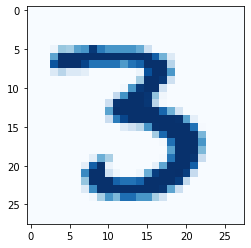

In [5]:
plt.imshow(x_train[12,:,:,0]);

**OPTIONALLY**, as a final step of preprocessing, we can convert the output labels (digits) into "one-hot" vectors. For instance, the digit 2 will become `[0,0,1,0,...,0]`. In older versions of Keras, this was necessary when using the softmax output layer and the categorical cross-entropy loss function. In modern Keras versions, we can use the `sparse_categorical_crossentropy` loss function to keep things simpler, and this preprocessing can be skipped.

In [6]:
#y_train = keras.utils.to_categorical(y_train)
#y_test = keras.utils.to_categorical(y_test)

# For instance, here is how the first instance in the training set is encodes.
#y_train[0]

### Training the CNN

Now we have everything to train the CNN. As in the feedforward NN, we start by creating a `Sequential` model. (This means that our classifier consists of layers.)

Then, we alternate convolutional and pooling layers, as is customary in CNN. We use ReLU units in the hidden layers. Finally, we apply a `Flatten`, to convert the feature maps after the last pooling step into vectors. The final part of the model looks like a normal feedforward neural network: first, a standard hidden layer using 128 units, and finally the output softmax layer.

We train the model using the Adam optimizer. To keep things simple, we let it train for just one epoch; for real-world problems, there would be many epochs, probably using early stopping to determine when to terminate training.

In [7]:
num_classes = 10

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=256,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test));

235/235 [==============================] - 28s 119ms/step - loss: 0.2743 - accuracy: 0.9226 - val_loss: 0.0791 - val_accuracy: 0.9765


Please note that if you retrain the model, the result might be a slightly different, because of randomness in weight initialization and in the Adam optimizer.

We can evaluate as we did in the previous notebook, using `predict_class` and scikit-learn's `accuracy_score`, but we can also take a shortcut by calling `model.evaluate`.

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0791323184967041
Test accuracy: 0.9764999747276306


### Inspecting the output

Let's exemplify the classifier's output.

We first take a look at an instance from the test set. Let's say for instance that we look at the 100th instance (which happens to represent the number 6):

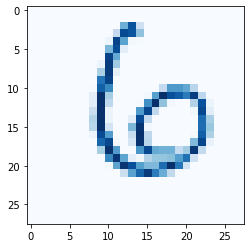

In [9]:
plt.imshow(x_test[100,:,:,0]);

We compute the predictions for all instances in the test set. We do this in two steps: first, we compute the probabilities predicted by the classifier using the softmax output for all instances in the test set. This gives us a $N$ x 10 matrix, where $N$ is the number of instances and 10 because there are 10 possible digits (from 0 to 9). Secondly, for each row (test set instance), we find the digit that has the highest probability.

As you can see, the model has made a correct prediction for the 100th instance.

In [10]:
predicted_probs = model.predict(x_test)

guesses = predicted_probs.argmax(axis=-1)

guesses[100]

6

We make a small helper function that sorts the probabilities and prints them in the sorted order.

Again considering the 100th instance, we see that it has been determined to be an image of the digit 6 with a probability very close to 1.

In [11]:
def print_probs(ps):
    for p, i in sorted([(p, i) for i, p in enumerate(ps)], reverse=True):
        print(f'{i}: {p:.4f}')

print_probs(predicted_probs[100])

6: 0.9972
0: 0.0015
8: 0.0007
5: 0.0003
4: 0.0001
2: 0.0001
1: 0.0000
9: 0.0000
3: 0.0000
7: 0.0000


Finally, let's inspect some of the errors.

We gather all misclassified instances in a list. For each misclassified instance, we store the output probability of the guessed class, the probabilities of all classes, the true digit class, and the image.

We sort the list by the output probabilities, so that the first instances in the list are those where the classifier had a (misguided) high confidence in the erroneous predictions.

As you can see, 187 out of the 10,000 test instances were misclassified. [Again, this number may vary if you retrain the model, because of randomness in the training process.]

In [12]:
errors = []

for x, y, g, p in zip(x_test, y_test, guesses, predicted_probs):    
    if y != g:
        errors.append( (p[g], p, y, x[:,:,0]) )

errors.sort(reverse=True)

len(errors)

235

Here is the instance where the classifier was most confident in its incorrect prediction. In this case, this is an instance of the digit 6, which was misclassified as a 4. This instance is quite hard to classify even for the human eye.

[Again, you may see a different result if you retrain.]

Correct label: 6
0: 0.9990
6: 0.0009
9: 0.0000
5: 0.0000
2: 0.0000
8: 0.0000
3: 0.0000
4: 0.0000
7: 0.0000
1: 0.0000


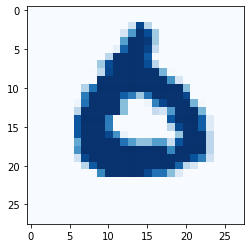

In [13]:
def show_error(err):
    _, p, label, img = err    
    print('Correct label:', label)
    print_probs(p)
    plt.imshow(img)
        
show_error(errors[0])